In [2]:
### Imports

import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from src.helpers import *
from sklearn.metrics import *

import pickle
import math

import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

from pyaldata import *

In [3]:
def preprocess(data_file):
    # Load TrialData .mat file into a DataFrame
    group_df = mat2dataframe(data_file, shift_idx_fields=True, td_name='grp')
    trial_df = mat2dataframe_NC(data_file, shift_idx_fields=True, td_name = 'trial_data') 
    # The main dataframe here is trial_df, the group one will be used 
    # if needed to add some variables to the other one.
    df = trial_df
    # Combine time-bins into longer ones
    td = combine_time_bins(df, 2)
    # Remove low-firing neurons
    td = remove_low_firing_neurons(td, "M1_spikes",  5)
    td = remove_low_firing_neurons(td, "PMd_spikes", 5)
    # Transform signals
    td = transform_signal(td, "M1_spikes",  'sqrt')
    td = transform_signal(td, "PMd_spikes", 'sqrt')
    # Merge signals
    # Signals from the pre-motor and motor cortex are now combines in one same variable, 
    # we do not consider the 2 regions as different but more as functionally working together.
    td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")
    # Compute firing rates
    td = add_firing_rates(td, 'smooth')

    # Here we need to put all end indices together (even if the trial is considered bad)
    # to create the time windows. 
    td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
    # Apply the function to each row
    td['bad_indices'] = td.apply(find_bad_indices, axis=1)

    # Merge the 2 tables
    td_all = pd.concat([td,group_df.drop(columns = 'type')], axis = 1)
    cols_to_search = ['index', 'num', 'type', 'tonic_stim_params','KUKAPos',
               'idx_kuka_go', 'idx_reach', 'idx_end_complete',
               'bad_indices', 'x', 'y', 'z', 'angles', 'both_spikes', 'both_rates']
    cols_to_keep = [c for c in cols_to_search if c in td_all.columns]
    td_filt = td_all[cols_to_keep]
    td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])
    td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])

    tidy_df = build_tidy_df(td_filt, start_margin = 5)
    tidy_df['target_pos'] = tidy_df.apply(lambda x: np.concatenate([x['x'][4:5], x['y'][4:5], x['z'][4:5]]), axis = 1)
    tidy_df['id'] = tidy_df['trial_num'].astype(str) + '_' + tidy_df['reach_num'].astype(str)

    return tidy_df


In [4]:
name = 'Sansa'
date = '0504'

data_dir = "./Data"
fname = os.path.join(data_dir, "Sansa_2018"+date+".mat")
tidy_data = preprocess(fname)

/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


array field StimParamNames could not be converted to int.
array field emg_names could not be converted to int.
array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.
field idx_bad could not be converted to int.
field idx_decode_reach could not be converted to int.
field idx_sent_reach could not be converted to int.


/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]
/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/tmp/ipykernel_526170/726885678.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_filt['test_start'] = t

In [32]:
def min_max_normalize(vector, mins, maxs):
    """
    Normalize a vector between 0 and 1 using Min-Max normalization.

    Args:
    - vector (numpy array): The input vector to be normalized.

    Returns:
    - normalized_vector (numpy array): The normalized vector.
    """
    norm_vec = np.zeros_like(vector)
    for i in range(0, vector.shape[1]):
        norm_vec[:,i] = (vector[:,i] - mins[i]) / (maxs[i] - mins[i])

    return norm_vec

In [33]:
def min_max(vector):
    mins = []
    maxs = []
    for i in range(0, vector.shape[1]):
        mins.append(np.min(vector[:,i]))
        maxs.append(np.max(vector[:,i]))
    return mins, maxs

In [21]:
def train_test_split(df, train_variable = 'both_rates', 
                     target_variable = 'x', num_folds = 5, stim_params = False, 
                     no_outliers = False):

    """ This function creates disctionnaries to organize the data to perform 
    cross-fold validation. 
    For each fold, we will shuffle the reach trials and use 5 for training, 
    1 for validation, 1 for testing.
    
    Input:
        - df: pandas DataFrame with tidy data
        - target_variable: str, either x, y, z, or angle. Default x.
        - num_folds: (int), number of folds used for cross-validation. Default 5.

    Arguments:
        - stim_parameters: if the dataset has stimulation parameters and 
        we want to use them to make subsets for instance we want to keep them in data
        - no_outliers: if True, the training set (target) will be clean of outliers.
    
    Returns:
        - X_train, y_train, X_val, y_val, X_test, y_test: dictionnaries 
            containing the training, validation and testing data for each fold.
        - info_train, info_val, info_test: dictionnaries containing the information 
            for the rain, validation and test data not used for the model, 
            but important for the later data analysis.

    """

    random.seed(42)
    
    trial_ids = np.unique(df['id'].values)
    train_ids = [[] for _ in range(num_folds)] #generic to all folds
    val_ids = [[] for _ in range(num_folds)]  # Create empty lists for each fold
    test_ids = [[] for _ in range(num_folds)]  # Create empty lists for each fold

    num_test = max(int(np.round(0.2*len(trial_ids))),1)
    num_val = max(int(np.round(0.2*(len(trial_ids)-num_test))),1)
    print('Test trials ', num_test)
    print('Val trials', num_val)
    
        
    for i in range(num_folds):
        random.shuffle(trial_ids)
        test_ids[i].extend(trial_ids[-num_test:])
        remaining_ids = [j for j in trial_ids if j not in test_ids[i]]
        train_ids[i].extend(remaining_ids[:-num_val])
        val_ids[i].extend(remaining_ids[-num_val:])
        
    X_train = {}
    y_train = {}
    X_test = {}
    y_test = {}
    X_val = {}
    y_val = {}
    info_train = {}
    info_val = {}
    info_test = {}

    if stim_params:
        cols_search = [ 'id','num', 'type','stim_params','KUKAPos', 'trial_num', 'reach_num']
    else:
        cols_search = [ 'id','num', 'type','KUKAPos', 'trial_num', 'reach_num']
    info_cols = [c for c in cols_search if c in df.columns]

    for fold_idx in range(num_folds):
        #print('fold',fold_idx, ' train_ids ',train_ids[fold_idx])
        #print('fold',fold_idx, ' val_ids ',val_ids[fold_idx])
        #print('fold',fold_idx, ' test_ids ',test_ids[fold_idx])

        df_train = df.loc[df['id'].isin(train_ids[fold_idx])]
        df_val = df.loc[df['id'].isin(val_ids[fold_idx])]
        df_test = df.loc[df['id'].isin(test_ids[fold_idx])]

        train_info = df_train[info_cols]
        X_train_ = np.stack(df_train[train_variable], axis = 0)
        y_train_ = np.array(df_train[target_variable].tolist())
        val_info = df_val[info_cols]
        X_val_ =  np.stack(df_val[train_variable], axis = 0)
        y_val_ =  np.array(df_val[target_variable].tolist())
        test_info = df_test[info_cols]
        X_test_ =  np.stack(df_test[train_variable], axis = 0)
        y_test_ =  np.array(df_test[target_variable].tolist())

        if no_outliers is True:
            df_train['target_no_outliers'] = outliers_removal(df_train[target_variable])
            y_train_ = np.array(df_train['target_no_outliers'].tolist())
            df_val['target_no_outliers'] = outliers_removal(df_val[target_variable])
            y_val_ = np.array(df_val['target_no_outliers'].tolist())


        scaler = StandardScaler().fit(X_train_)

        X_train_ = scaler.transform(X_train_)
        X_val_ = scaler.transform(X_val_)
        X_test_ = scaler.transform(X_test_)


        X_train['fold'+str(fold_idx)] = X_train_
        #use training data to compute min and max values
        mins, maxs = min_max(y_train)
        # apply min-max normalization with those values for training and val
        y_train['fold'+str(fold_idx)] = min_max_normalize(y_train_, mins, maxs)
        X_val['fold'+str(fold_idx)] = X_val_
        y_val['fold'+str(fold_idx)] = min_max_normalize(y_val_, mins, maxs)
        X_test['fold'+str(fold_idx)] = X_test_
        y_test['fold'+str(fold_idx)] = y_test_ # min_max_normalize(y_test_)
        info_train['fold'+str(fold_idx)] = train_info
        info_val['fold'+str(fold_idx)] = val_info
        info_test['fold'+str(fold_idx)] = test_info

    return X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test, mins, maxs

"\n        scaler = StandardScaler().fit(X_train_)\n\n        X_train_ = scaler.transform(X_train_)\n        X_val_ = scaler.transform(X_val_)\n        X_test_ = scaler.transform(X_test_)\n\n\n        X_train['fold'+str(fold_idx)] = X_train_\n        y_train['fold'+str(fold_idx)] = min_max_normalize(y_train_)\n        X_val['fold'+str(fold_idx)] = X_val_\n        y_val['fold'+str(fold_idx)] = min_max_normalize(y_val_)\n        X_test['fold'+str(fold_idx)] = X_test_\n        y_test['fold'+str(fold_idx)] = min_max_normalize(y_test_)\n        info_train['fold'+str(fold_idx)] = train_info\n        info_val['fold'+str(fold_idx)] = val_info\n        info_test['fold'+str(fold_idx)] = test_info\n\n    return X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test "

In [22]:
y_train,  y_val,  y_test = train_test_split(tidy_data, train_variable = 'both_rates', 
                                            target_variable = 'target_pos', num_folds = 5,
                                            no_outliers = True)

Test trials  27
Val trials 21


/tmp/ipykernel_526170/1526780704.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target_no_outliers'] = outliers_removal(df_train[target_variable])
/tmp/ipykernel_526170/1526780704.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['target_no_outliers'] = outliers_removal(df_val[target_variable])


In [34]:
mins, maxs = min_max(y_train)

In [35]:
y_val_norm = min_max_normalize(y_val, mins, maxs)

In [37]:
y_test_norm = min_max_normalize(y_test, mins, maxs)

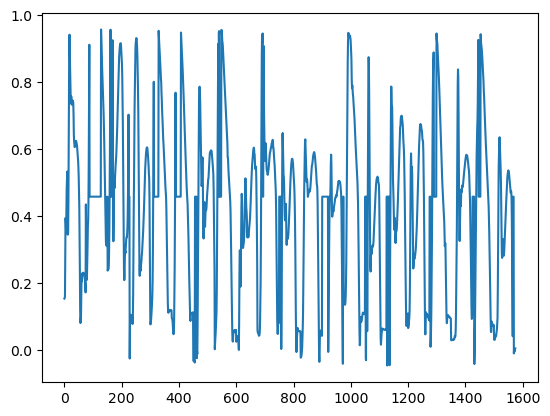

In [36]:
plt.plot(y_val_norm[:,0])

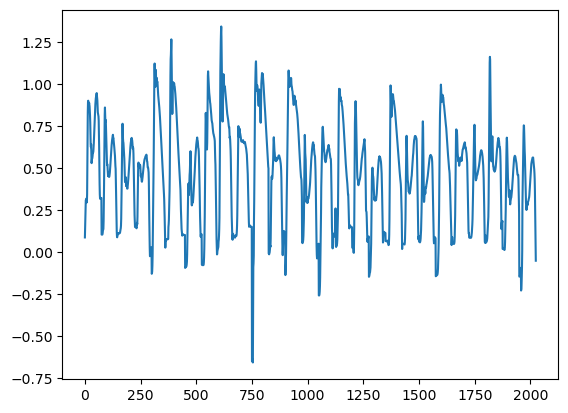

In [38]:
plt.plot(y_test_norm[:,0])

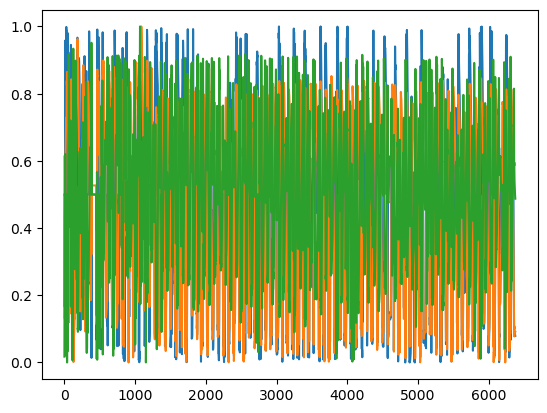

In [26]:
plt.plot(min_max_normalize(y_train, train = True)[0])